## HW 2: Crossentropy method
_Reference: based on Practical RL course by YSDA_

<!-- In this notebook you have to solve two simple RL problems with crossentropy method. -->

<!-- To get used to `gymnasium` package, please, refer to the [documentation](https://gymnasium.farama.org/introduction/basic_usage/). -->

<!-- In the end of the notebook, please, copy the functions you have implemented to file `template_crossentropy.py` and submit it to the Contest. -->

В этом ноутбуке тебе нужно решить две простые задачи обучения с подкреплением (RL) с помощью метода кросс-энтропии (cross-entropy method).

Чтобы познакомиться с пакетом gymnasium, пожалуйста, обратись к [документации](https://gymnasium.farama.org/introduction/basic_usage/).

В конце ноутбука скопируй функции, которые ты реализовал, в файл `template_crossentropy.py` и отправь его на Контест.

In [1]:
# !pip install gymnasium

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd
%matplotlib inline

import template_crossentropy

## Part 1. Tabular Cross Entropy
<!-- Let's consider discrete game "Taxi".

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations. -->

Рассмотрим дискретную игру «Taxi».

В мире с сеткой 5×5 есть четыре обозначенные точки для посадки и высадки пассажиров: Красная, Зелёная, Жёлтая и Синяя. Такси начинает игру с случайной клетки, а пассажир находится в одной из обозначенных точек.

<!-- The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends. -->
Цель — переместить такси к месту, где находится пассажир, подобрать его, затем перевезти в указанное место назначения и высадить. После успешной высадки пассажира эпизод завершается.

<!-- The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received. -->
Игрок получает положительные награды за успешную высадку пассажира в правильном месте и отрицательные награды за:
- неправильные попытки подобрать или высадить пассажира,
- а также за каждый шаг, на котором не получена другая награда

Полное описание среды можно найти [здесь](https://gymnasium.farama.org/environments/toy_text/taxi/).

<!-- ![Taxi-v3](https://gymnasium.farama.org/_images/taxi.gif) -->

<!-- So here's how it works: -->

In [3]:
# !pip install "gymnasium[toy-text]"

In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()

# plt.imshow(env.render())

(249, {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)})

#### Тест на соответствие

In [5]:
env.close()

In [6]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


Давай выполним действие 1 и посмотрим, что произойдёт:

In [7]:
next_state, reward, is_done, _, _ = env.step(1)

In [8]:
print(f"We got to state {next_state}, the reward is {reward}, game is not finished because is_done={is_done}")

We got to state 149, the reward is -1, game is not finished because is_done=False


### Create stochastic policy

На этот раз наша политика (policy) должна быть распределением вероятностей:

```policy[s,a] = P(take action a | in state s)```

Так как мы по-прежнему используем целочисленные представления состояний и действий, можно использовать двумерный массив для представления политики.

Пожалуйста, инициализируйте политику равномерно, то есть вероятности всех действий должны быть одинаковыми.


In [9]:
policy = np.ones((n_states, n_actions)) / n_actions

In [10]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

### Play the game

<!-- Just like before, but we also record all states and actions we took. -->

Так же, как и раньше, но мы также записываем все состояния и действия, которые выполняли.

Выбираем действие (например, с помощью `np.random.choice()`) из доступных действий и делаем шаг в среде с помощью `env.step()`.

<!-- Sample the action (e.g. `np.random.choice()`) from available actions and make a step in the environment using `env.step()`. -->

In [11]:
print(np.arange(0, n_actions))
print(policy[0])
np.random.choice(np.arange(0, n_actions), p=policy[0])

[0 1 2 3 4 5]
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


1

In [12]:
s, a, r = template_crossentropy.generate_session(env=env, policy=policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float64]

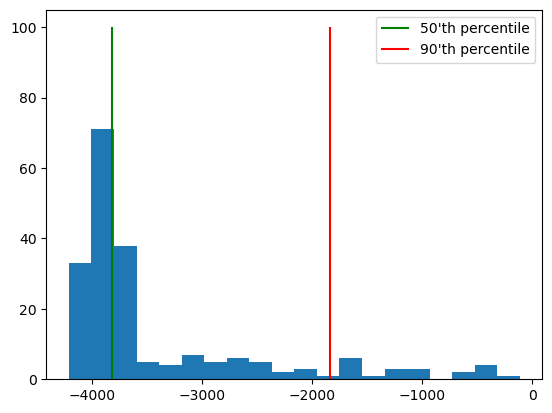

In [13]:
# давайте посмотрим на первоначальное распределение вознаграждений
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [template_crossentropy.generate_session(env=env, policy=policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [14]:
np.percentile(sample_rewards, 50)

-3821.5

### Crossentropy method steps

In [15]:
import numpy as np

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
percentile_value = 50

result = np.percentile(data, percentile_value)
print(f"{percentile_value}-й процентиль: {result}")

50-й процентиль: 5.5


In [16]:
states_batch = [[1, 2, 3],[4, 2, 0, 2],[3, 1],]
actions_batch = [[0, 2, 4],[3, 2, 0, 1],[3, 3],]
rewards_batch = [3, 4, 5,]

test_result_0 = template_crossentropy.select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = template_crossentropy.select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = template_crossentropy.select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = template_crossentropy.select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

In [17]:
assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"

assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"

assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"

assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")

Ok!


In [18]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = template_crossentropy.update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."

assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"

assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")

Ok!


### Training loop
Generate sessions, select N best and fit to those.

In [19]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [20]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions

mean reward = -46.320, threshold=-40.000


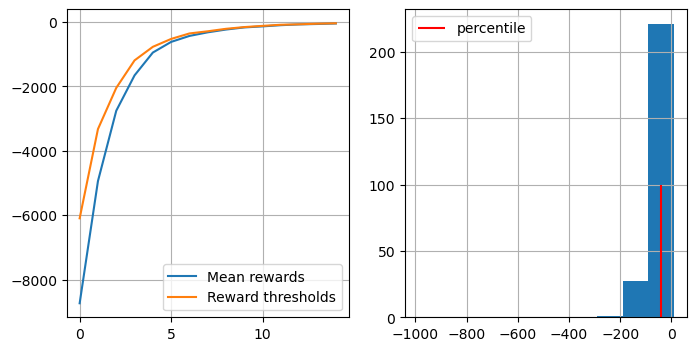

You Win!


In [21]:
n_sessions = 250  
percentile = 50  
learning_rate = 0.5

log = []

for i in range(100):
    %time
    sessions = [template_crossentropy.generate_session(env, policy) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = template_crossentropy.select_elites(states_batch, actions_batch, rewards_batch, percentile)
    new_policy = template_crossentropy.update_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    # display results on chart
    show_progress(rewards_batch, log, percentile)
    if np.mean(rewards_batch) > -50:
        print("You Win!")
        break

Поздравляю! Вы только что обучили свою первую модель RL!

Now copy functions from this notebook to `template_crossentropy.py` and submit it to the Contest problem `Tabular CrossEntropy`.

## Part 2: Approximate crossentropy and neural nets.

В этом разделе вы обучите политику нейронной сети для игры с непрерывным пространством состояний

Вы можете найти полное описание среды [тут](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).

<!-- ![CartPole-v0"](https://www.gymlibrary.dev/_images/cart_pole.gif) -->

Итак, вот как это работает:

In [69]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n

/opt/anaconda3/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [70]:
# plt.imshow(env.render())
# [x, x_dot, theta, theta_dot]

Для такой простой сети можно использовать sklearn, но мы рекомендуем вам написать решение с помощью PyTorch ;)

In [71]:
state = env.reset()[0]
print("x = {}\nx_dot = {}\ntheta = {}\ntheta_dot = {}".format(*state))

x = -0.046522628515958786
x_dot = 0.04120974615216255
theta = 0.0398680716753006
theta_dot = 0.04012656956911087


In [78]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
X_train = [state] * n_actions
y_train = range(n_actions)
agent.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64,), max_iter=1000, random_state=42)

Update the generate_session function and beat the game!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


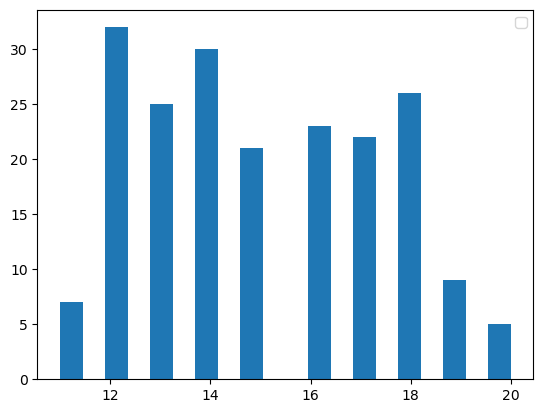

In [88]:
def generate_session_cartpole(t_max=300):
    states, actions = [], []
    total_reward = 0
    s, info = env.reset()
    for t in range(t_max):
        prob = agent.predict_proba([s])[0]
        # print(sum(prob))
        a = np.random.choice(np.arange(len(prob)), p=prob)
        new_s, r, done, truncated, info = env.step(a)
        states.append(s.astype(dtype="object"))
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states, actions, total_reward

import matplotlib.pyplot as plt
%matplotlib inline

n = 200
sample_rewards = [0] * 200
for i in range(200):
    sample_rewards[i] = generate_session_cartpole()[2]

plt.hist(sample_rewards, bins=20)
plt.legend()

mean reward = 229.140, threshold=335.200


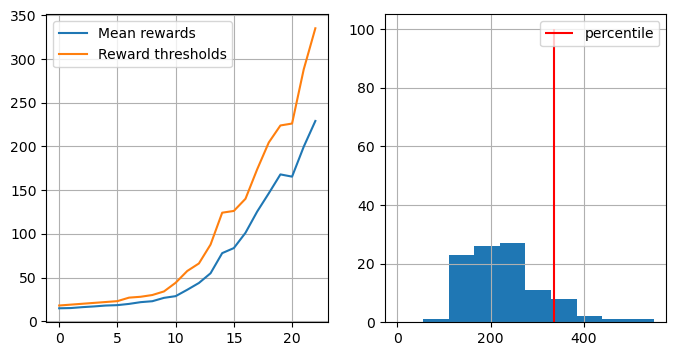

You Win!


In [89]:
n_sessions = 100
percentile = 90
log = []

for i in range(100):
    sessions = [generate_session_cartpole(t_max=1000) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = template_crossentropy.select_elites(states_batch, actions_batch, rewards_batch, percentile)
    agent.fit(elite_states, elite_actions)
    if max(rewards_batch) > min(rewards_batch):
        show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])
    if np.mean(rewards_batch) > 210:
        print("You Win!")
        break

### Submission generation
To generate submission run the following block of code and submit the generated file to the contest problem `CrossEntropy CartPole`.

In [90]:
# DO NOT CHANGE THIS BLOCK
sessions = [generate_session_cartpole() for _ in range(n_sessions)]
states_batch, actions_batch, rewards_batch = zip(*sessions)
elite_states, elite_actions = template_crossentropy.select_elites(states_batch, actions_batch, rewards_batch, percentile)

sessions_to_send = []
for session in sessions:
  observations = [x.tolist() for x in session[0]]
  actions = [x.item() for x in session[1]]
  sessions_to_send.append((observations, actions))

import json
with open('sessions_to_send.json', 'w') as iofile:
  json.dump(sessions_to_send, iofile, ensure_ascii=True, indent=4)
# DO NOT CHANGE THIS BLOCK